#**Import Libraries**



In [64]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

# **Supress Warnings**

In [65]:
warnings.filterwarnings("ignore")

# **Load and preprocess training data**

In [66]:
train_data = pd.read_excel("01 Train Data.xlsx")
train_data = train_data.drop_duplicates(subset=["Email ID"])

# **Data inspection**

In [67]:
print("Training Data Information:")
print(train_data.info())

Training Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 4836
Data columns (total 23 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   First Name                                                       1987 non-null   object 
 1   Email ID                                                         1987 non-null   object 
 2   Quantity                                                         1987 non-null   int64  
 3   Price Tier                                                       0 non-null      float64
 4   Ticket Type                                                      1987 non-null   object 
 5   Attendee #                                                       1765 non-null   float64
 6   Group                                                            0 non-null      float64
 7   Order Type          

In [68]:
print("Sample of Training Data:")
print(train_data.head())

Sample of Training Data:
  First Name           Email ID  Quantity  Price Tier             Ticket Type  \
0     ANIKET     aniket@xyz.com         1         NaN  Art of Resume Building   
1  Dhanshree  dhanshree@xyz.com         1         NaN  Art of Resume Building   
2     Dhiraj     dhiraj@xyz.com         1         NaN  Art of Resume Building   
3      Pooja      pooja@xyz.com         1         NaN  Art of Resume Building   
4     Aayush     aayush@xyz.com         1         NaN  Art of Resume Building   

     Attendee #  Group  Order Type Currency  Total Paid  ...  Attendee Status  \
0  2.213855e+09    NaN  Free Order      USD           0  ...        Attending   
1  2.213859e+09    NaN  Free Order      USD           0  ...        Attending   
2  2.213862e+09    NaN  Free Order      USD           0  ...        Attending   
3  2.213988e+09    NaN  Free Order      USD           0  ...        Attending   
4  2.214567e+09    NaN  Free Order      USD           0  ...        Attending   

 

# **Data cleaning and preprocessing**

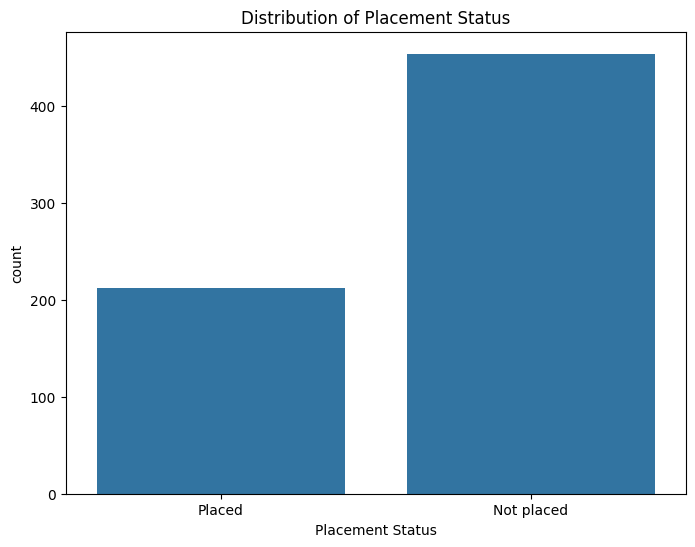

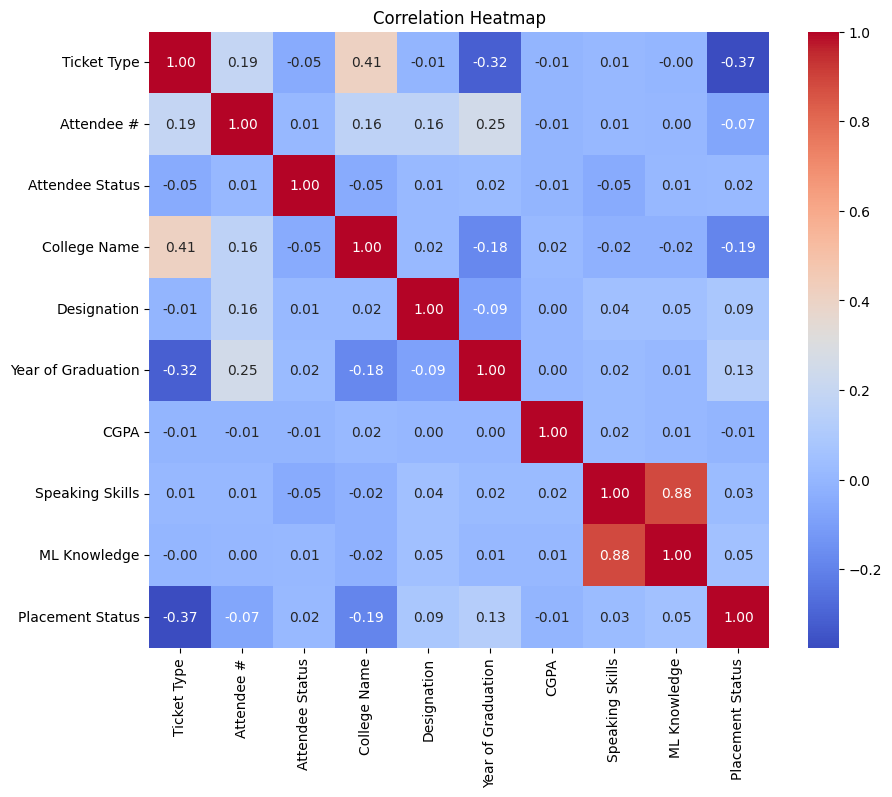

In [69]:
train_data_backup = copy.deepcopy(train_data)

# Select useful columns
useful_columns = ["Ticket Type", "Attendee #", "Attendee Status", "College Name",
                  "Designation", "Year of Graduation", "CGPA", "Speaking Skills",
                  "ML Knowledge", "Placement Status"]

train_data = train_data[useful_columns]

# Data Visualization - Distribution of Placement Status
plt.figure(figsize=(8, 6))
sns.countplot(x="Placement Status", data=train_data)
plt.title("Distribution of Placement Status")
plt.show()

# Handle missing values and encode target variable
train_data['Placement Status'].fillna(train_data['Placement Status'].mode()[0], inplace=True)
train_data['Placement Status'] = train_data['Placement Status'].map({'Placed': 1, 'Not placed': 0})

# Identify numerical and categorical columns
numerical_columns = ["Attendee #", "CGPA", "Speaking Skills", "ML Knowledge"]
categorical_columns = ["Ticket Type", "Attendee Status", "College Name", "Designation", "Year of Graduation"]

# Impute numerical columns
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_columns] = numerical_imputer.fit_transform(train_data[numerical_columns])

# Scale numerical columns
scaler = StandardScaler()
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

# Encode categorical columns
for column in categorical_columns:
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column])

# Data Visualization - Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# **Train-Test Split**

In [70]:
x = train_data.drop("Placement Status", axis=1)
y = train_data["Placement Status"]
x
y

0       1
1       0
2       0
3       0
4       1
       ..
4829    0
4831    0
4832    0
4834    0
4836    0
Name: Placement Status, Length: 1987, dtype: int64

# **Check class distribution**

In [71]:
print("Class distribution in training data:")
print(y.value_counts())

Class distribution in training data:
Placement Status
0    1775
1     212
Name: count, dtype: int64


# **Data Balance using SMOTE**

In [72]:
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

# **Train-Test split**

In [73]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# **Models and their parameter grids**

In [74]:
models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
    }),
    'GradientBoosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],  # Adjust learning rate
        'max_depth': [5, 7, 9],             # Adjust max depth
    }),
    'SVM': (SVC(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
    }),
    'LogisticRegression': (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs', 'saga'],
    })
}

best_models = {}

# **Model Training and Evaluation**

In [75]:
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Model Evaluation on Validation Set
for model_name, model in best_models.items():
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Best parameters for SVM: {'C': 10, 'kernel': 'poly'}
Best parameters for LogisticRegression: {'C': 10, 'solver': 'liblinear'}
RandomForest - Accuracy: 0.9127, Precision: 0.9157, Recall: 0.9127
GradientBoosting - Accuracy: 0.9197, Precision: 0.9210, Recall: 0.9197
SVM - Accuracy: 0.8310, Precision: 0.8762, Recall: 0.8310
LogisticRegression - Accuracy: 0.8437, Precision: 0.8749, Recall: 0.8437


# **Determine best model**

In [76]:
best_model_name = max(best_models, key=lambda k: accuracy_score(y_val, best_models[k].predict(x_val)))
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name}")

Best Model: GradientBoosting


# **Feature Importance**

In [77]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances:")
print(feature_importance_df)

Feature importances:
              Feature    Importance
0         Ticket Type  6.175558e-01
6                CGPA  1.031645e-01
1          Attendee #  1.014499e-01
3        College Name  8.331885e-02
8        ML Knowledge  6.629734e-02
7     Speaking Skills  2.785350e-02
2     Attendee Status  3.600162e-04
4         Designation  6.080372e-08
5  Year of Graduation  5.904304e-08


# **Load and preprocess test data**

In [78]:
test_data = pd.read_excel("02 Test Data.xlsx")
test_data = test_data.drop_duplicates(subset=["Email ID"])

test_data_backup = copy.deepcopy(test_data)

useful_columns = ["Ticket Type", "Attendee #", "Attendee Status", "College Name",
                  "Designation", "Year of Graduation", "CGPA", "Speaking Skills", "ML Knowledge"]
test_data = test_data[useful_columns]

numerical_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
numerical_imputer = SimpleImputer(strategy='mean')
test_data[numerical_columns] = numerical_imputer.fit_transform(test_data[numerical_columns])

scaler = StandardScaler()
test_data[numerical_columns] = scaler.fit_transform(test_data[numerical_columns])

categorical_columns = ["Ticket Type", "Attendee Status",
                       "College Name", "Designation", "Year of Graduation"]

for column in categorical_columns:
    le = LabelEncoder()
    test_data[column] = le.fit_transform(test_data[column])

# **Predict on test data using the best model**

In [79]:
predictions = best_model.predict(test_data)

# **Convert predictions to "Yes"/"No"**

In [80]:
predictions = ["Yes" if pred == 1 else "No" for pred in predictions]

# **Add predictions to the output DataFrame**

In [81]:
output_df = test_data_backup[["First Name", "Email ID", "College Name", "CGPA", "Speaking Skills", "ML Knowledge"]].copy()
output_df["Placement Status"] = predictions

# **Save to Excel file**

In [82]:
output_df.to_excel("Prediction of Placement Status.xlsx", index=False)

# **Visualizations**

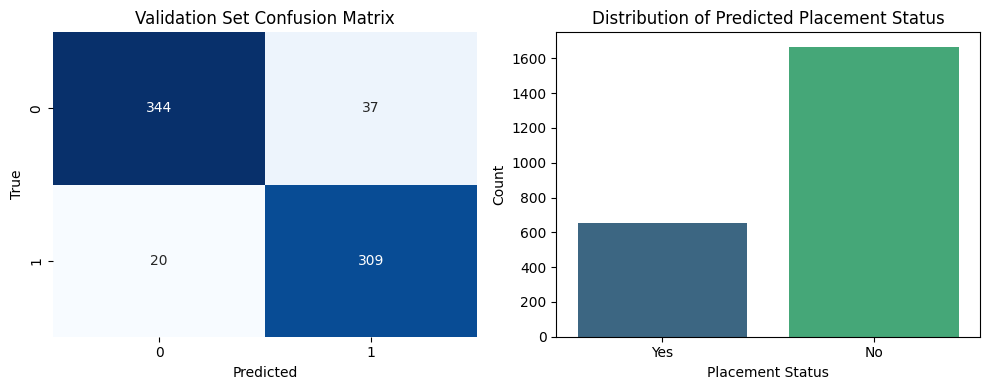

In [83]:
cm_val = confusion_matrix(y_val, best_model.predict(x_val))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Distribution of predicted placement status
plt.subplot(1, 2, 2)
sns.countplot(x=predictions, palette="viridis")
plt.title("Distribution of Predicted Placement Status")
plt.xlabel("Placement Status")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# **Evaluation on Test set**

In [84]:
test_data_backup["Placement Status"].fillna(0, inplace=True)
y_true_test = test_data_backup["Placement Status"].apply(lambda x: "Yes" if x == 1 else "No")

accuracy_test = accuracy_score(y_true_test, predictions)
precision_test = precision_score(y_true_test, predictions, average='weighted')
recall_test = recall_score(y_true_test, predictions, average='weighted', zero_division=0)

print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.7177940542869453
